In [1]:
import numpy as np
from numba import cuda
import numba as numba
import math
import matplotlib.pyplot as plt

In [2]:
def gpu_total_memory():
    return cuda.current_context().get_memory_info()[1]

In [3]:
def gpu_compute_capability():
    return cuda.get_current_device().compute_capability

In [4]:
def gpu_name():
    return cuda.get_current_device().name

In [5]:
def max_float64s():
    return gpu_total_memory()/8

In [6]:
def map_64():
    from map_parallel import sArray
    M = max_float64s()
    N = int(M/2000)
    x = np.linspace(0,1,N,dtype = np.float64)
    y = sArray(x)
    plt.plot(x,y)
    

In [7]:
@cuda.jit(device = True)
def f(x, r):
    '''
    Execute 1 iteration of the logistic map
    '''
    return r*x*(1 - x)

In [44]:
@cuda.jit
def logistic_map_kernel(ss, r, x, transient, steady):
    '''
    Kernel for parallel iteration of logistic map

    Arguments:
        ss: 2D numpy device array to store steady state iterates for each value of r
        r: 1D  numpy device array of parameter values
        x: float initial value
        transient: int number of iterations before storing results
        steady: int number of iterations to store
    '''
    n = len(r)
    i = cuda.grid(1)
    ss[0,i] = f(x,r[i])
    for k in range(transient):
        ss[0,i] = f(ss[0,i],r[i])
    for k in range(steady):
        ss[k+1,i] = f(ss[k,i],r[i])

In [35]:
def parallel_logistic_map(r, x, transient, steady):
    '''
    Parallel iteration of the logistic map

    Arguments:
        r: 1D numpy array of float64 parameter values
        x: float initial value
        transient: int number of iterations before storing results
        steady: int number of iterations to store
    Return:
        2D numpy array of steady iterates for each entry in r
    '''
    TPB = 32
    n = len(r)
    d_r = cuda.to_device(r)
    ss = cuda.device_array((steady,n), dtype = np.float64)
    blockDims = TPB
    gridDims = (n+TPB-1)//TPB
    logistic_map_kernel[gridDims, blockDims](ss, d_r, x, transient, steady)
    return ss.copy_to_host()

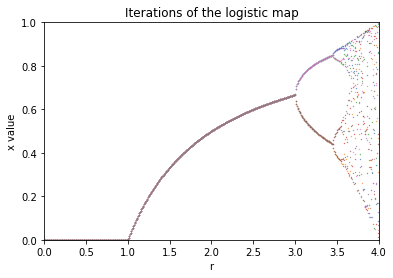

In [55]:
transient = 1000
steady = 8
x = 0.5
r = np.linspace(0,4,500)
ss = parallel_logistic_map(r , x , transient , steady)
for i in range(steady):
    plt.scatter(r,ss[i,:],s = 0.1)
plt.axis([0,4, 0, 1])
plt.xlabel('r')
plt.ylabel('x value')
plt.title('Iterations of the logistic map')
plt.show()